## Imports and dataset

In [1]:
from src.models.conjugate_bayes_lin_reg import FlatPriorLinearRegression, NormalInverseGammaPriorLinearRegression, NormalKnownVariancePriorLinearRegression
from src.utils import id, expy2

from src.attacks.point_attacks import attack, attack_fgsm, true_gradient_mean, reparametrization_trick, det_attack

import numpy as np
import torch
from torch.optim import Adam
import pandas as pd

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import gaussian_kde

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid", palette="muted", font="serif")

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
plt.rcParams.update({
    'axes.titlesize': 18,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'axes.titleweight': 'bold',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1,
    'grid.alpha': 0.5,
    'grid.linestyle': '--',
    'legend.fontsize': 12,
    'legend.frameon': False,
    'figure.dpi': 300,  
})

In [3]:
# set all seeds for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Wine dataset

In [4]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

In [5]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
# Fit the model
model = NormalInverseGammaPriorLinearRegression(prior_params={
    'mu': torch.zeros(X_train.shape[1]), 
    'lam': torch.eye(X_train.shape[1]), 
    'a': torch.tensor([1]), 
    'b': torch.tensor([1])},)
data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
model.fit(data)

/home/pgarcia/AdvReg/src/models/conjugate_bayes_lin_reg.py:119: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1724788957849/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  b_n = self.b + 0.5 * (y.T @ y + self.mu.T @ self.lam @ self.mu - mu_n.T @ lam_n @ mu_n)


In [7]:
model.sample_predictive_distribution(torch.tensor(X_test[17,:], dtype=torch.float32).unsqueeze(1), 1000).mean()

tensor(4.6087)

## Check gradient estimation

Text(0.5, 0, 'Log10(Samples)')

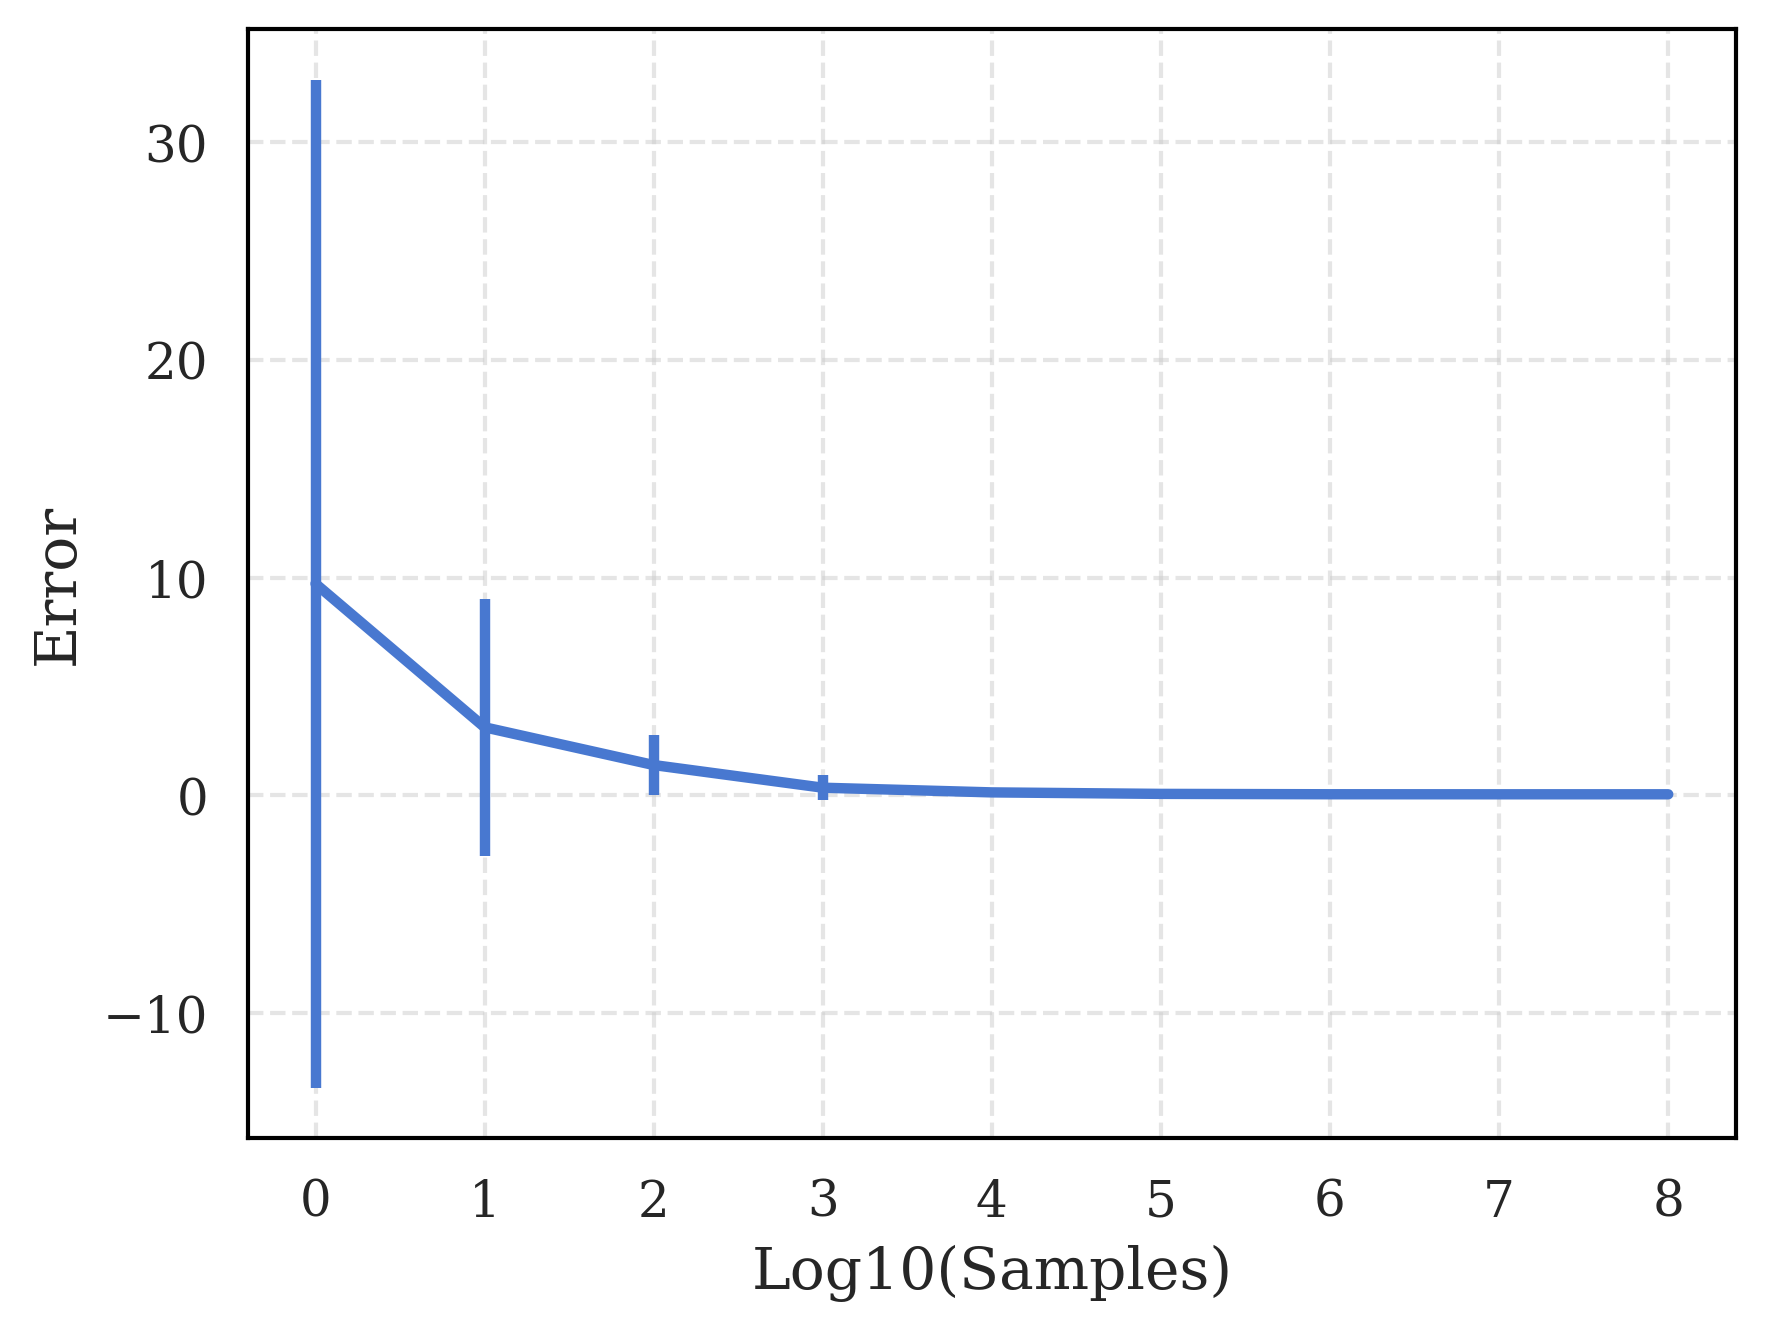

In [8]:
# Vemos como funciona la aproximacion del gradiente segun el numero de samples de reparametrization trick
diffs_total = []
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)
y_star = 6.0

for _ in range(9):
    diffs = []

    exact_gradient = true_gradient_mean(x_adv, model, y_star)
    for samples in range(9):
        rep_gradients, _, _ = reparametrization_trick(x_adv, model, y_star, 10 ** samples, id)
        diffs.append(torch.norm(rep_gradients - exact_gradient).item())
        x_adv.grad.zero_()
    diffs_total.append(diffs)

# plot the mean and std of the losses
plt.errorbar(range(9), np.mean(diffs_total, axis=0), yerr=2*np.std(diffs_total, axis=0))
plt.ylabel('Error')
plt.xlabel('Log10(Samples)')

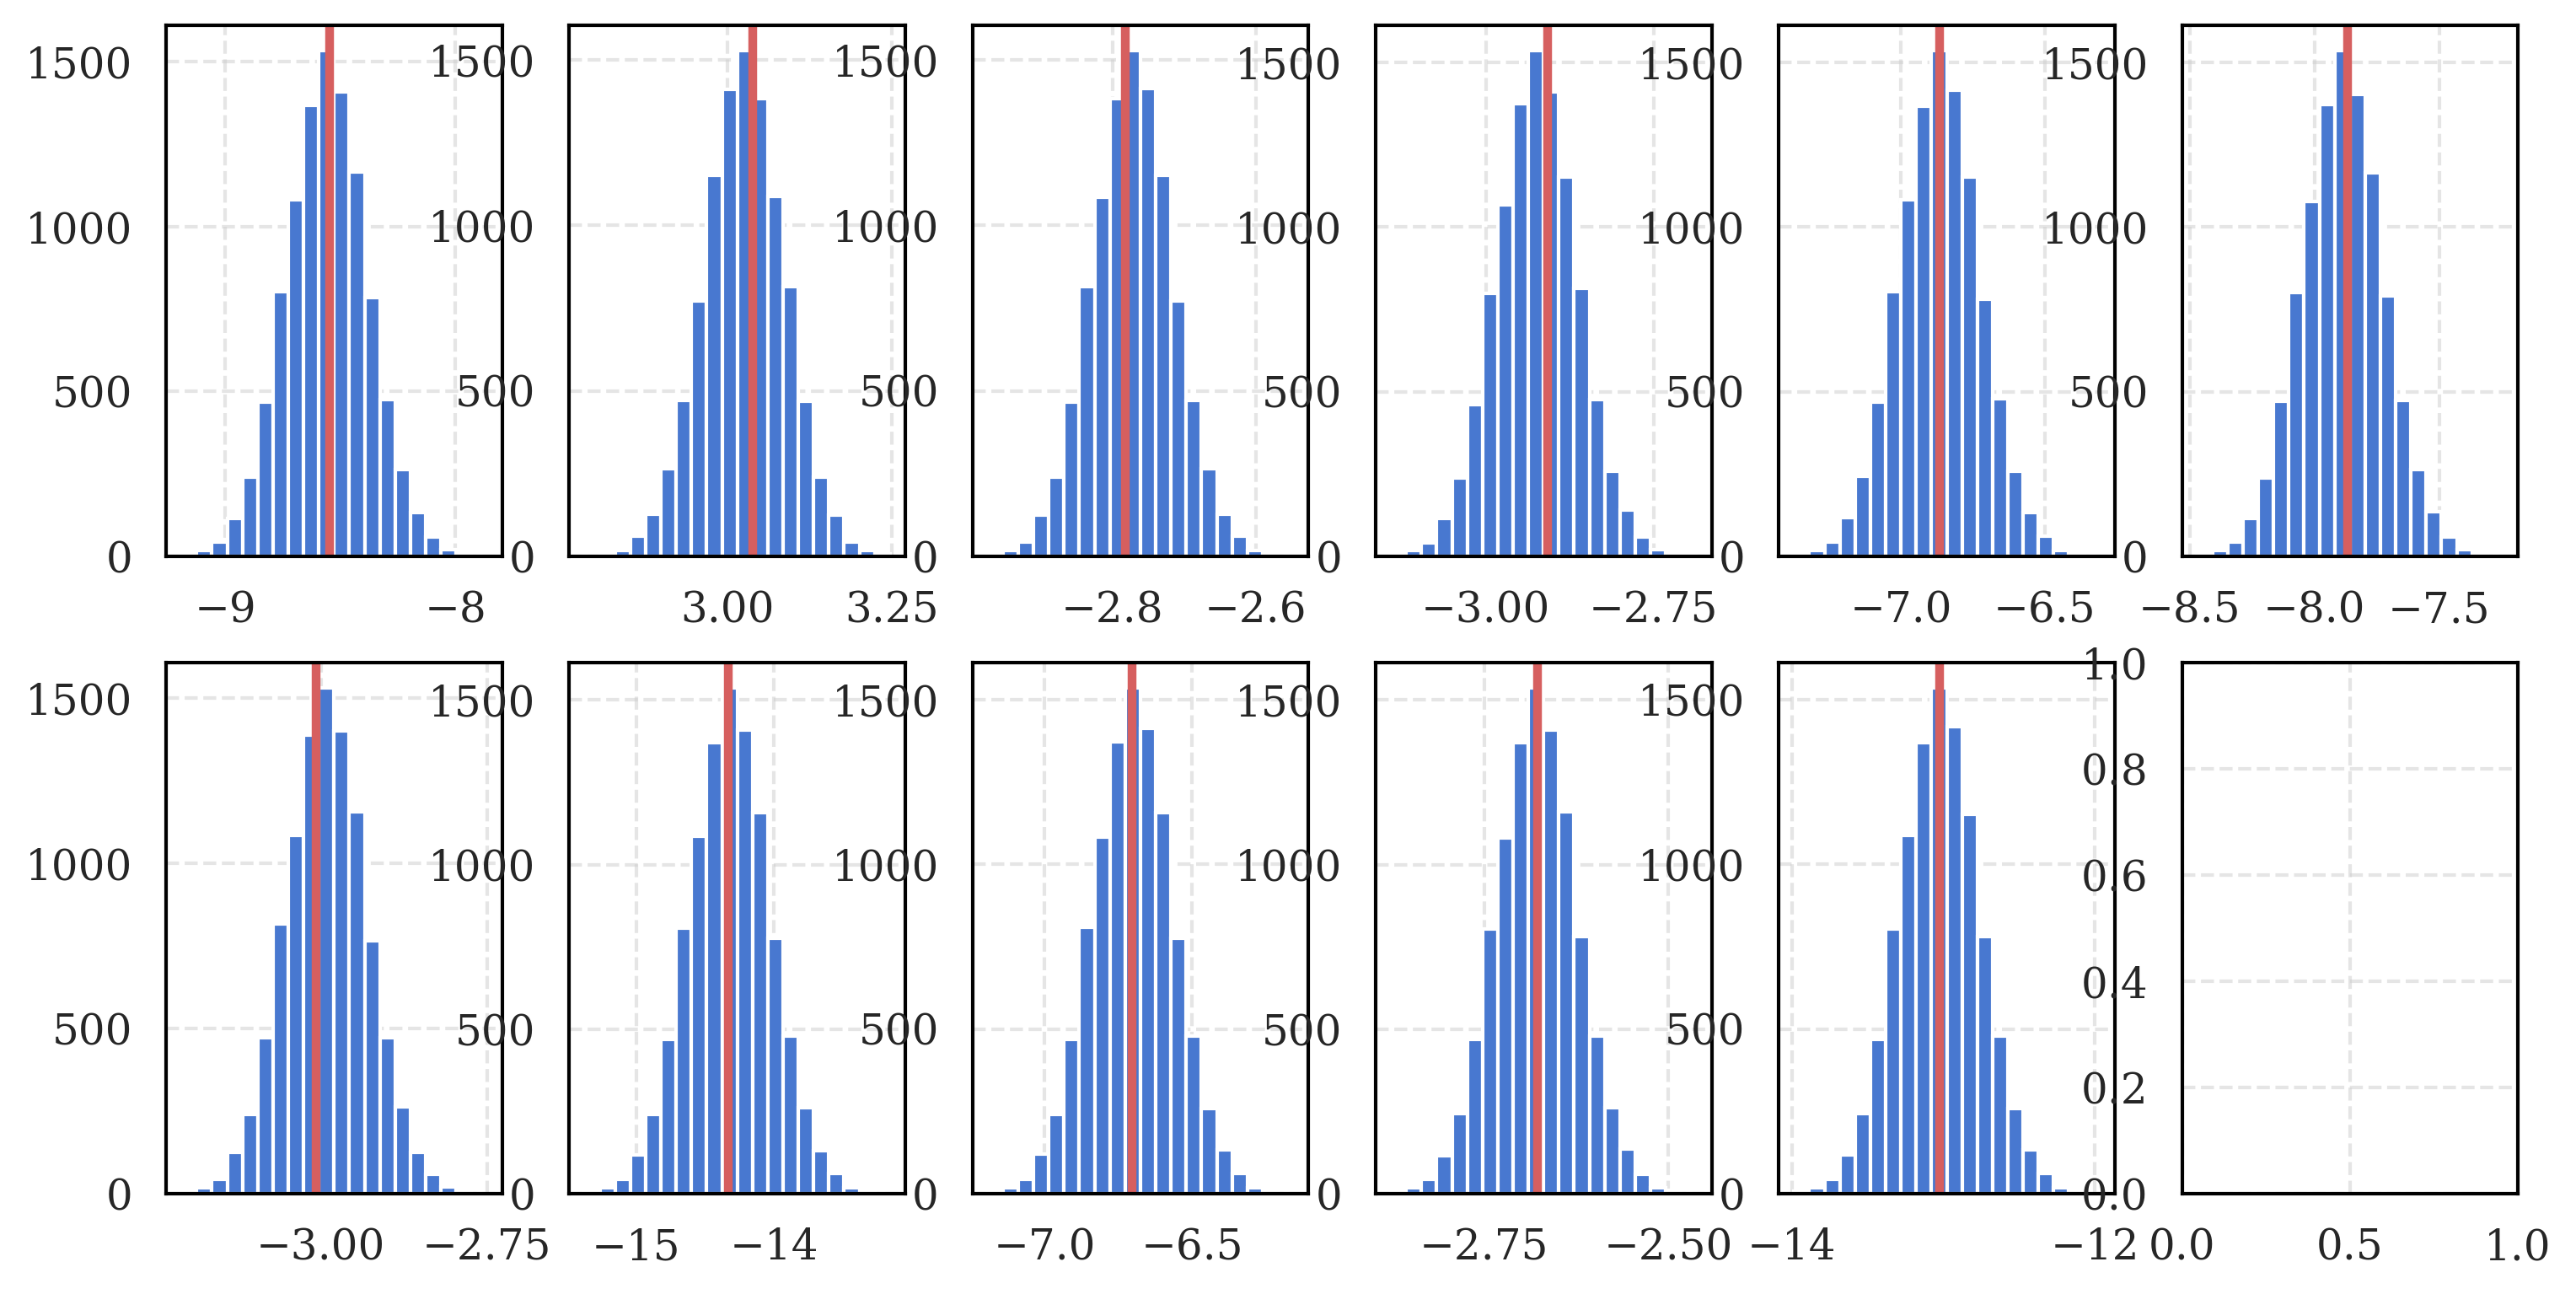

In [9]:
x_adv = torch.tensor(X_test[17,:], dtype=torch.float32, requires_grad=True)
y_star = 6.0
grads_estim = []
exact_gradient = true_gradient_mean(x_adv, model, y_star)

for _ in range(10000):
    rep_gradients, _, _ = reparametrization_trick(x_adv, model, y_star, 1000, id)
    grads_estim.append(rep_gradients.clone().numpy())
    x_adv.grad.zero_()
    

# plot histogram of gradients
fig, axs = plt.subplots(2, 6, figsize=(12, 6))
for i in range(11):
    axs[i // 6, i % 6].hist(np.array(grads_estim)[:, i], bins=20)
    # plot line at exact_gradient[i]
    axs[i // 6, i % 6].axvline(exact_gradient[i].item(), color='r')


## Attack with mean as objective function

<>:33: SyntaxWarning: invalid escape sequence '\e'
<>:33: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2524011/4089541069.py:33: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


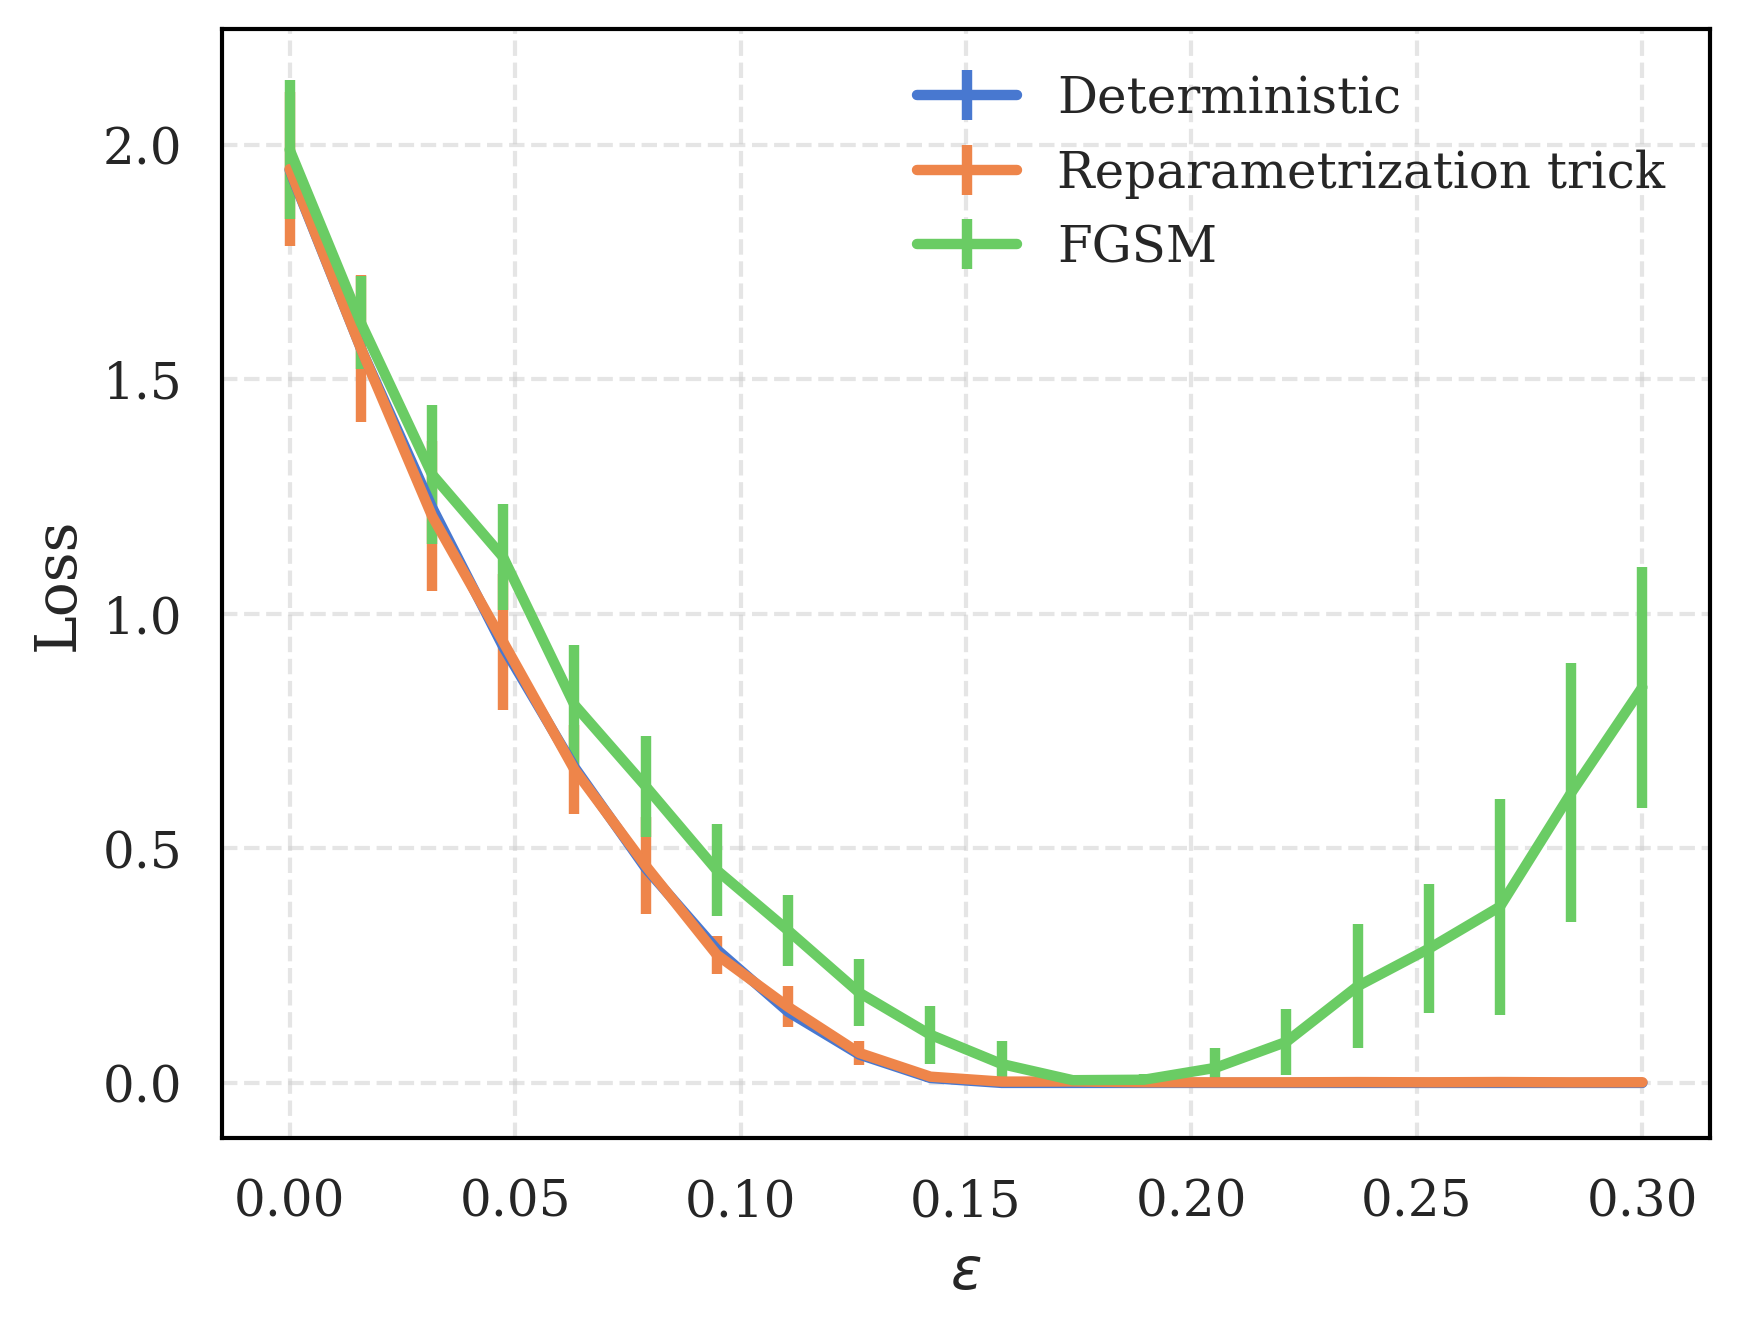

In [10]:
# Plot loss as a function of the size of the perturbation for both deterministic and reparametrization trick attacks
losses_det_all = []
losses_rep_all = []
losses_fgsm_all = []
epsilons = np.linspace(0, .3, 20)

for _ in range(10):
    losses_det = []
    losses_rep = []
    losses_fgsm = []

    for epsilon in epsilons:
        x_adv_det, y_adv_det = det_attack(X_test[17,:].copy(), model, y_star, epsilon, verbose=False)
        losses_det.append((y_adv_det - y_star) ** 2)

        x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32)
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-3, func=id)  
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1], dtype=torch.float32).unsqueeze(1), 1000).mean()
        losses_rep.append((y_adv - y_star) ** 2)

        x_adv_fgsm = attack_fgsm(torch.tensor(X_test[17,:].copy(), dtype=torch.float32), model, y_star, epsilon=epsilon)
        y_adv_fgsm = model.sample_predictive_distribution(x_adv_fgsm.unsqueeze(1), 1000).mean()
        losses_fgsm.append((y_adv_fgsm - y_star) ** 2)

    losses_det_all.append(losses_det)
    losses_rep_all.append(losses_rep)
    losses_fgsm_all.append(losses_fgsm)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_det_all, axis=0), yerr=2*np.std(losses_det_all, axis=0), label='Deterministic')
plt.errorbar(epsilons, np.mean(losses_rep_all, axis=0), yerr=2*np.std(losses_rep_all, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_fgsm_all, axis=0), yerr=2*np.std(losses_fgsm_all, axis=0), label='FGSM')
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.legend()

## Attack with exp(y^2/100) as objective function

In [11]:
ys = model.sample_predictive_distribution(torch.tensor(X_test[17,:], dtype=torch.float32).unsqueeze(1), 1000)
func = torch.exp(ys ** 2 / 100)
func.mean()

tensor(1.2529)

<>:30: SyntaxWarning: invalid escape sequence '\e'
<>:30: SyntaxWarning: invalid escape sequence '\e'
/tmp/ipykernel_2524011/2571766599.py:30: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('$\epsilon$')


(-0.1, 3.5)

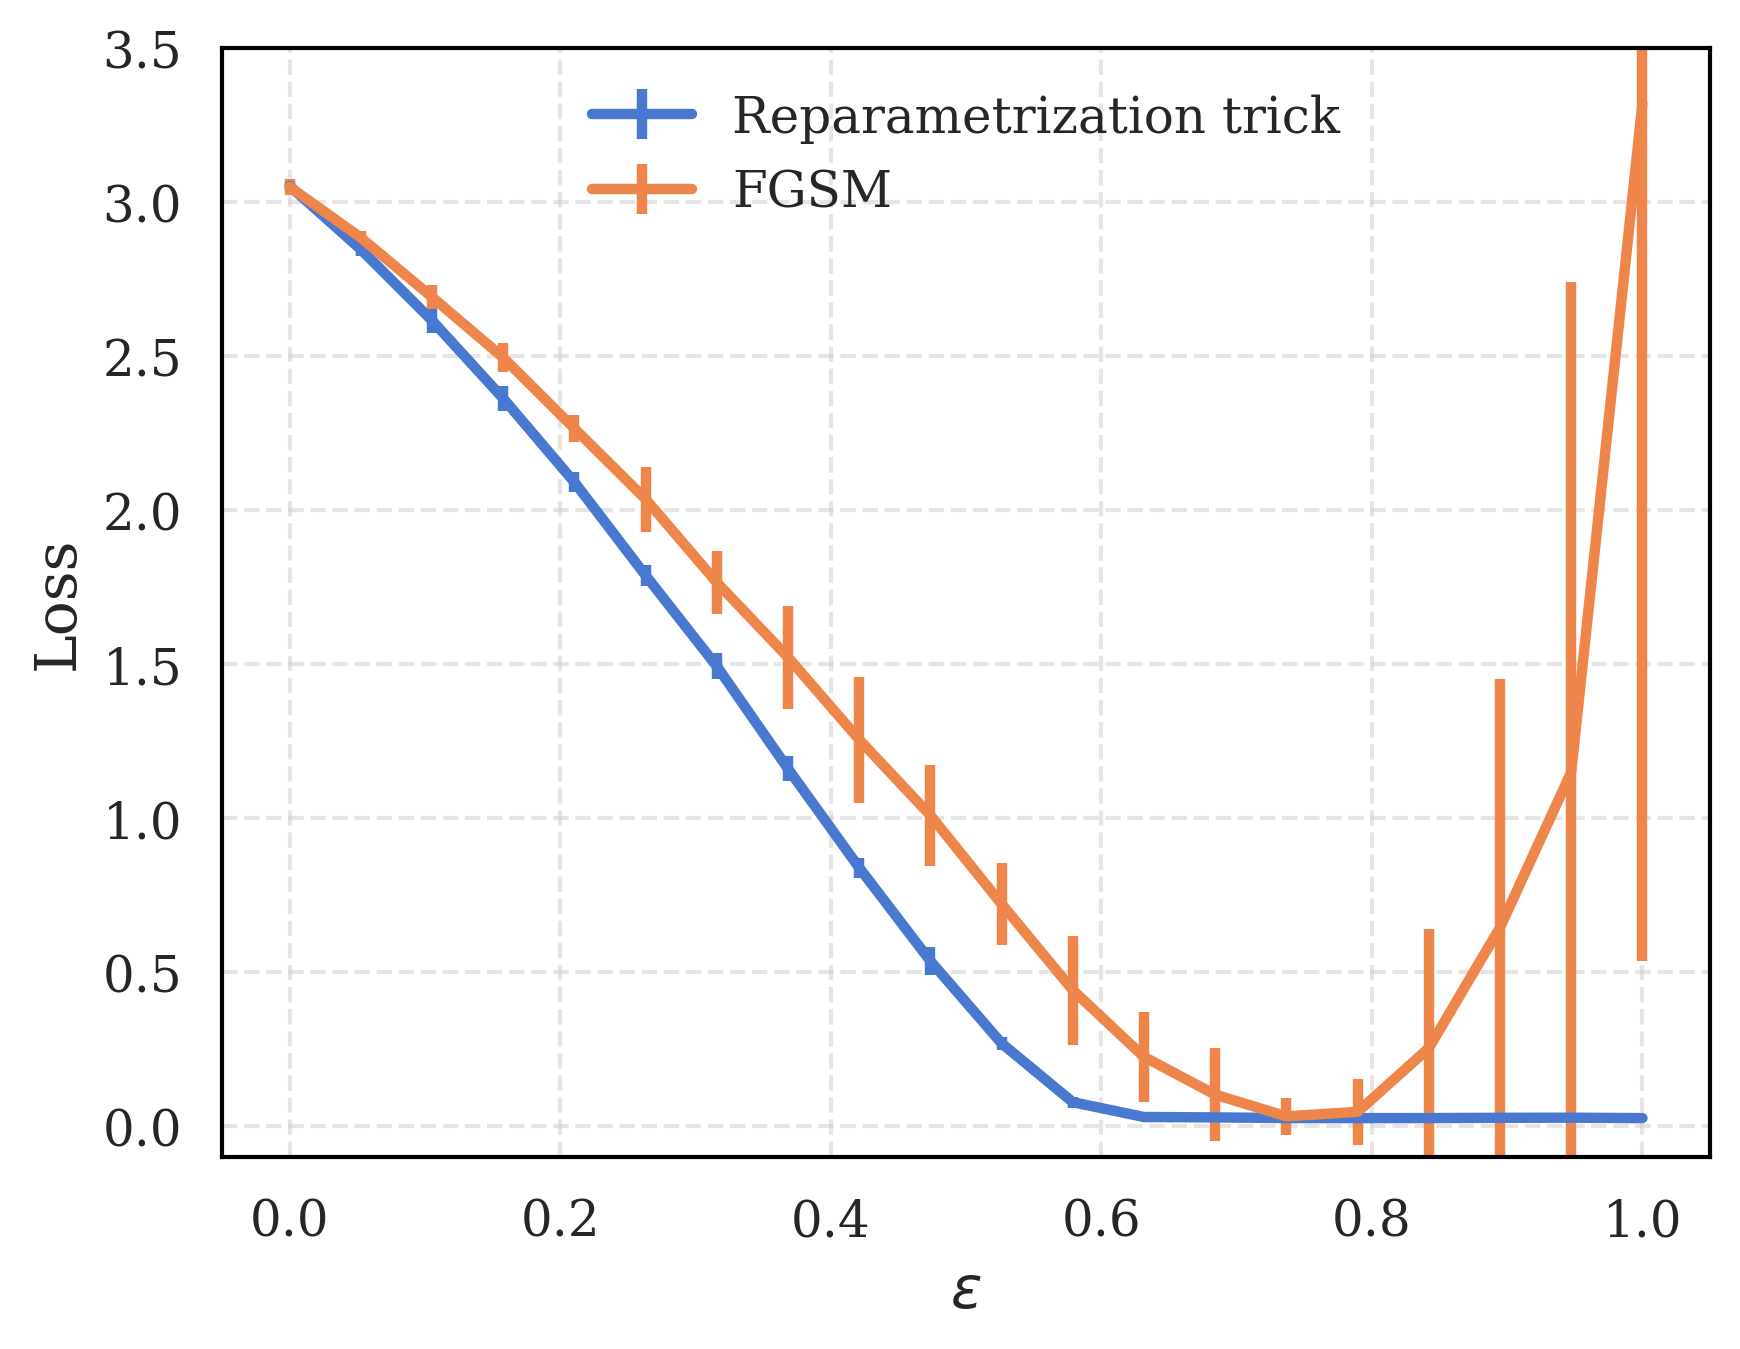

In [12]:
# Plot loss as a function of the size of the perturbation for reparametrization trick attack
x_adv = torch.tensor(X_test[17,:].copy(), dtype=torch.float32, requires_grad=True)
y_star = 3.0
losses_total_rep = []
losses_total_fgsm = []
epsilons = np.linspace(0, 1, 20)

for _ in range(10):
    losses_rep = []
    losses_fgsm = []

    for epsilon in epsilons:
        x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-3, num_iterations=1000, samples_per_iteration=1000, func=expy2)    
        y_adv = model.sample_predictive_distribution(torch.tensor(x_adv_values[-1]).unsqueeze(1), 1000)
        func_mean = torch.exp(y_adv ** 2 / 100).mean()
        losses_rep.append((func_mean - y_star) ** 2)
        x_adv_fgsm = attack_fgsm(x_adv, model, y_star, epsilon=epsilon, func=expy2)
        y_adv_fgsm = model.sample_predictive_distribution(x_adv_fgsm.unsqueeze(1), 1000)
        func_mean = torch.exp(y_adv_fgsm ** 2 / 100).mean()
        losses_fgsm.append((func_mean - y_star) ** 2)


    losses_total_rep.append(losses_rep)
    losses_total_fgsm.append(losses_fgsm)

# plot the mean and std of the losses
plt.errorbar(epsilons, np.mean(losses_total_rep, axis=0), yerr=2*np.std(losses_total_rep, axis=0), label='Reparametrization trick')
plt.errorbar(epsilons, np.mean(losses_total_fgsm, axis=0), yerr=2*np.std(losses_total_fgsm, axis=0), label='FGSM')
plt.legend()
plt.xlabel('$\epsilon$')
plt.ylabel('Loss')
plt.ylim(-0.1, 3.5)

## Variance as objective

In [13]:
y_star = 30
epsilon = 2
x_adv = X_test[17,:].copy()
x_adv = torch.tensor(x_adv, dtype=torch.float32, requires_grad=True)

def var(x, y):
    return torch.var(y)

x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, learning_rate= 1e-2, samples_per_iteration=1000, num_iterations=100, epsilon=epsilon, func=var)

Text(0.5, 0, 'y')

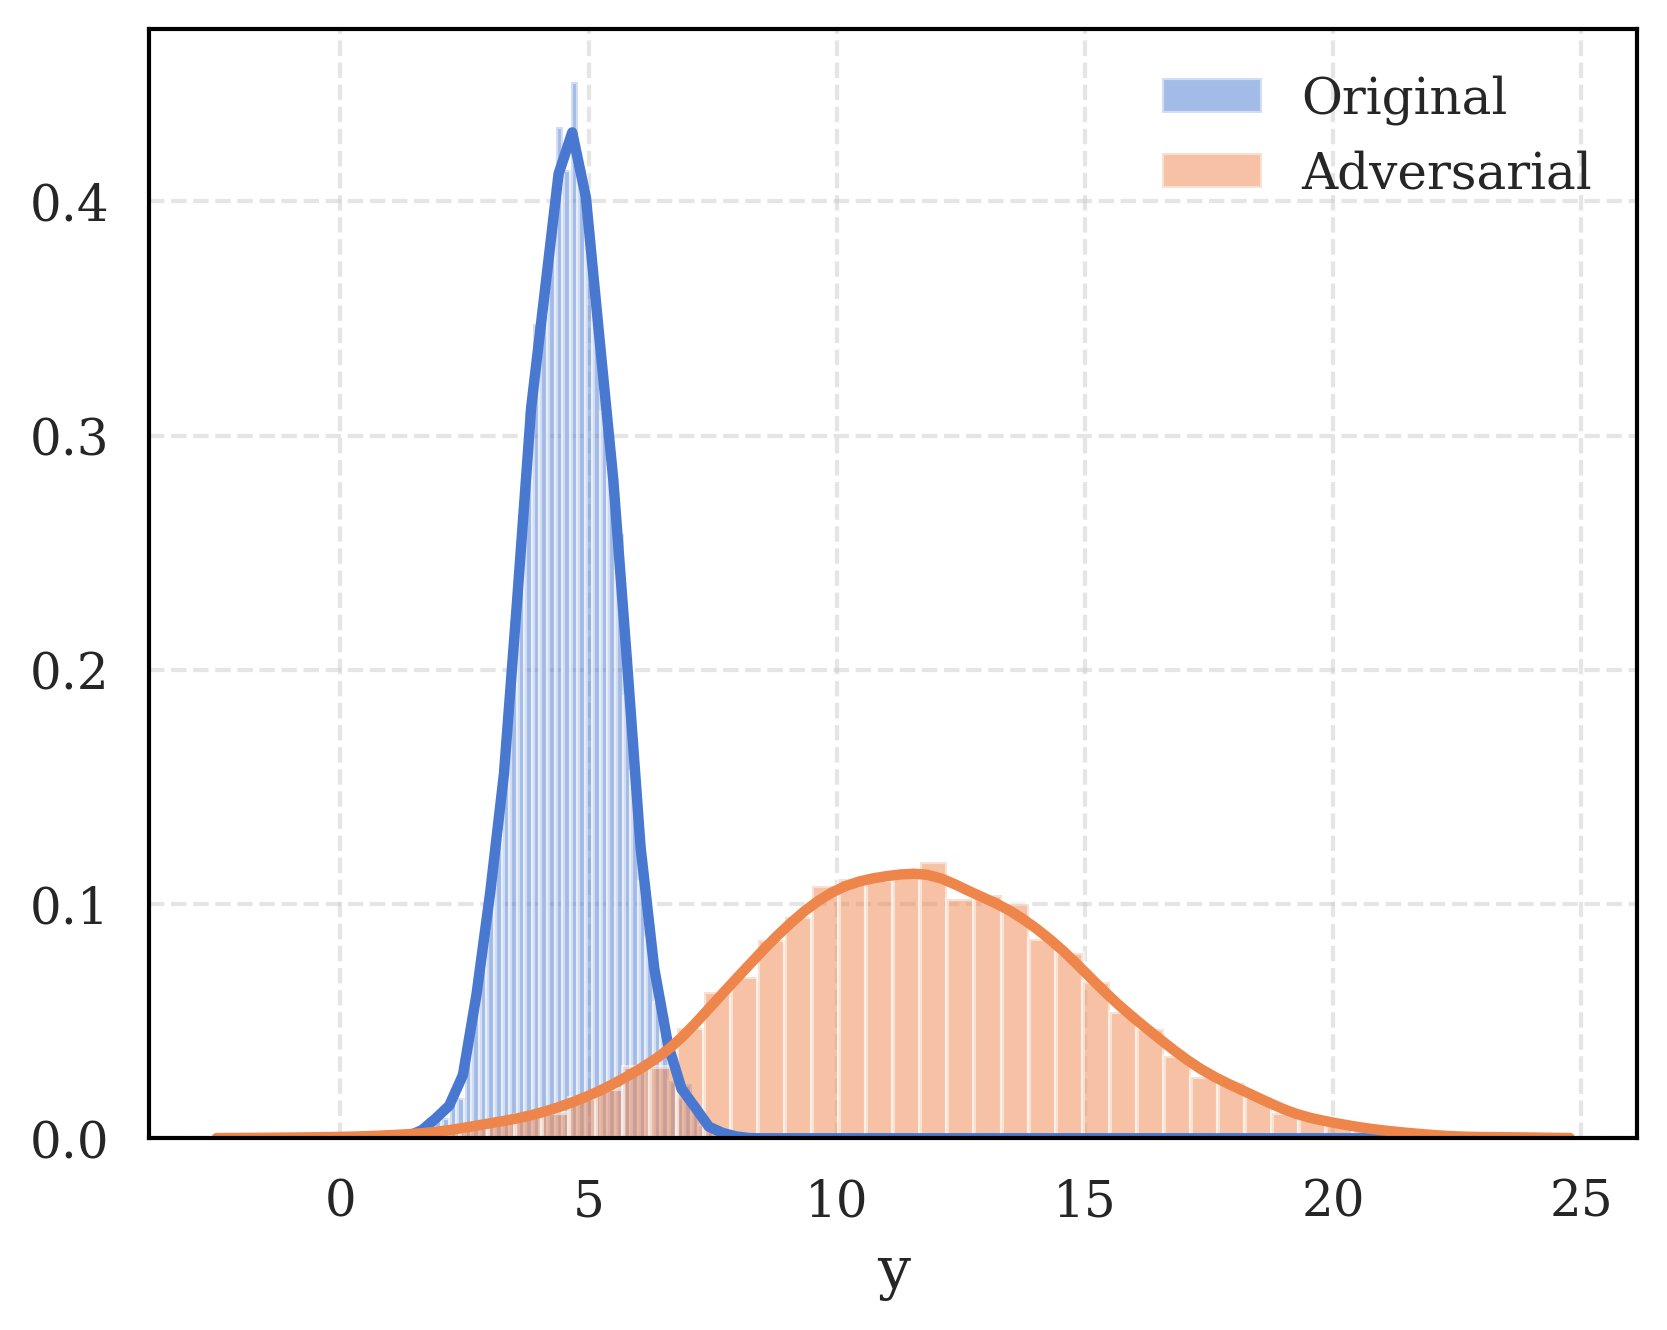

In [14]:
y_samples = model.sample_predictive_distribution(x_adv.unsqueeze(1), num_samples=10000).numpy()
y_adv_samples = model.sample_predictive_distribution(
    torch.tensor(x_adv_values[-1], dtype=torch.float32).unsqueeze(1), num_samples=10000).numpy()

kde = gaussian_kde(y_samples.T)
kde_adv = gaussian_kde(y_adv_samples.T)

plt.hist(y_samples, bins=50, alpha=0.5, label='Original', density=True)
plt.hist(y_adv_samples, bins=50, alpha=0.5, label='Adversarial', density=True)

ys = np.linspace(
    min(np.min(y_samples), np.min(y_adv_samples)), 
    max(np.max(y_samples), np.max(y_adv_samples)), 
    100)
# plot with same color and label
plt.plot(ys, kde(ys), color='C0')
plt.plot(ys, kde_adv(ys), color='C1')
plt.legend()
plt.xlabel('y')

# Comparison of 3 datasets: Wine, energy and housing

In [4]:
# Load the dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
data = pd.read_excel(url)

# The last two columns are the target variables (Heating Load and Cooling Load)
X = data.iloc[:, :-2].values  # Covariates
y = data.iloc[:, -2].values  # Heating Load

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_energy_train, X_energy_test, y_energy_train, y_energy_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [5]:
# Wine Quality dataset with response in {3, 4, 5, 6, 7, 8}, 11 features and 4898 samples

# URL to the Wine Quality dataset (for example, from UCI Machine Learning Repository)
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
# Load the dataset directly into a Pandas DataFrame
data = pd.read_csv(url, delimiter=";")

X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [6]:
# Housing dataset
california_housing = fetch_california_housing(as_frame=True)

X = california_housing.data.values
y = california_housing.target.values

X_normalized = MinMaxScaler().fit_transform(X)

X_housing_train, X_housing_test, y_housing_train, y_housing_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42)

In [18]:
# For all 3 datasets: Fit the model, compute the average rmse over the test set for the original data and the adversarial examples with epsilon = 0.2 and epsilon = 0.5
datasets = ['energy', 'wine', 'housing']
epsilons = [0, 0.2, 0.5]

results = []

for dataset in datasets:
    print(f'Running dataset {dataset}')
    if dataset == 'energy':
        X_train, X_test, y_train, y_test = X_energy_train, X_energy_test, y_energy_train, y_energy_test
    elif dataset == 'wine':
        X_train, X_test, y_train, y_test = X_wine_train, X_wine_test, y_wine_train, y_wine_test
    elif dataset == 'housing':
        X_train, X_test, y_train, y_test = X_housing_train, X_housing_test, y_housing_train, y_housing_test
    y_star = y_train.mean() * 2

    model = NormalInverseGammaPriorLinearRegression(prior_params={
        'mu': torch.zeros(X_train.shape[1]), 
        'lam': torch.eye(X_train.shape[1]), 
        'a': torch.tensor([1]), 
        'b': torch.tensor([1])},)
    data = {'X': torch.tensor(X_train, dtype=torch.float32), 'y': torch.tensor(y_train, dtype=torch.float32)}
    model.fit(data)

    X_test = X_test[:100, :]
    y_test = y_test[:100]

    results_dataset = []
    for _ in range(10):
        res_it = []
        for epsilon in epsilons:
            rmse = []
            for i in range(X_test.shape[0]):
                x_adv = torch.tensor(X_test[i,:].copy(), dtype=torch.float32, requires_grad=True)
                x_adv_values, loss_values, func_values = attack(x_adv, model, y_star, epsilon=epsilon, learning_rate=1e-4, num_iterations=1000, early_stopping_patience=20)
                y_adv = model.mu @ x_adv_values[-1]
                rmse.append((y_adv - y_test[i]) ** 2)
            res_it.append(np.sqrt(np.mean(rmse)))
        results_dataset.append(res_it)
    results.append(results_dataset)

Running dataset energy


In [19]:
# Display as a table
results_array = np.array(results).mean(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,3.327,5.272,11.193
wine,0.963,1.859,4.411
housing,0.745,2.308,2.432


In [20]:
# Display as a table
results_array = 2 * np.array(results).std(axis=1)
results_array = np.round(results_array, 3)
results_df = pd.DataFrame(results_array, columns=epsilons, index=datasets)
results_df

,0.0,0.2,0.5
energy,0.0,0.000,0.009
wine,0.0,0.000,0.000
housing,0.0,0.001,0.001
